# Code:

1. Install Anaconda which provides Jupyter needed for Ipywidget
2. Install with Pip some libraries: 
    pip install psycopg2
    pip install ipywidgets
    jupyter nbextension enable --py widgetsnbextension
3. Run all the code (Cell/run all) . Cell 78: Interactive Plot

## Import:

In [1]:
# Global Import:
import math
import json
import sys
import numpy as np
from datetime import *
import dateutil.parser

#Import for Visualization:
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import matplotlib.image as mpimg

#Import for PostGresSQL DataBase ( WORK ONLY WITH A VPN):
import psycopg2
import ast

#Import for interactivity in the Jupyter Notebook:
from ipywidgets import interactive, HBox, Play, Text, jslink, VBox, SelectionSlider

## Functions:

In [2]:
def Timestudy(cursor, start, end):
    """This function helps to query the database to get the lines that 
    we want and to return the cursor will all data"""
    
    cursor.execute(f"select * from v1.observation where stream_id = 129 AND data ->> 'phenomenonTime' < '{end}'" 
                   f"and data ->> 'phenomenonTime' > '{start}' LIMIT 10000")

In [3]:
def Extract_array_json(cursor):
    """This function reads the cluster, extract the json files, and transfer everything 
    in a dictionnary with the timestmap as the key and the sound heat map as the value. 
    Time_HM is a list of all keys sorted. We also export the dictionnary and list with 
    datastamp under a string format for easier display later"""
    Dico_Time = {}
    Dico_Time_str={}
    Time_HM = []
    for row in cursor:
        json_data = str(row[1])
        b = ast.literal_eval(json_data)
        # On cherche toutes les clés possibles
        key_global = b.keys()
        key_result = b["result"].keys()

        #On regarde data
        dBA = b['result']["data"][0]
        dBA = np.array(dBA)
        dBA = dBA.astype(float)

        #On met en forme le temps
        Time = dateutil.parser.parse(b["phenomenonTime"])
        Time = Time + timedelta(hours=2)
        
        # On ajoute dans les liste 
        if np.nansum(dBA) > 50000:
            Time_HM.append(Time)
            Dico_Time[Time]= dBA
    
    Time_HM = sorted(Time_HM)
    Time_HM_str = [str(obj)[:-13] for obj in Time_HM ]
    
    for key in Dico_Time.keys():
        Dico_Time_str[str(key)[:-13]] = Dico_Time[key]

    return Dico_Time, Dico_Time_str, Time_HM, Time_HM_str

In [4]:
def Extract_HM (number, Dico_Time, Time_HM ):
    """ This function helps to extract a Sound Heat Map from the dictionnary using the Time_HM  list index   """
    HM = np.array(Dico_Time[Time_HM[number]])
    HM_datetime = Time_HM[number]
    return HM, HM_datetime

In [5]:
def Extract_HM_Hr (hr, Dico_Time):
    """This function helps to extract a sound heat map from the dictionnary. The results  """
    HM = np.array(Dico_Time[hr])
    return HM

In [6]:
def DrawMapLegend(HM, image) : 
    """
    This function draws a plot with the Sound Heat Map on a blueprint and change the symbology
    The Extent of the background must be chosen to fit the sound heat map extent
    """
    # we rotate and flip the map
    arr=np.rot90(HM)
    arr=np.flip(arr, axis=0)

    ### WITH BACKGROUND PNG:
    #subplot
    fig, ax = plt.subplots(figsize=(20,30))
    # Ajout du blueprint
    map_img = mpimg.imread(image) 
    plt.imshow(map_img, zorder=0, extent=[0,76, 0, 36])

    # Affichage de la grille interpollé
    ax = plt.gca()
    ax.set_aspect('equal')
    h = ax.contourf(arr,cmap="rainbow", alpha=0.6, levels = [50,60,70,80, 90, 100, 110, 116,130] )
    h1,l1 = h.legend_elements("L(dBC)")
    plt.legend(h1, l1, loc = 4, fontsize = 14)  

In [7]:
def VideoMapHr_keystr(hr):
    """
    Its Run the two functions : Extract_HM and DrawMapLegend
    It gives also the parameter of the first function(Dico_Time_str) to make it interactive using ipywidget
    """
    HM = Extract_HM_Hr(hr, Dico_Time_str)
    DrawMapLegend( HM = HM, image = 'Background3.png')

In [8]:
def AvgdB(SHMs):
    """Function to add many Sound Heat Maps"""
    nb = len(SHMs)
    dim = SHMs[0].shape
    somme = np.zeros(dim)
    for val in SHMs:    
        val = np.power(10,val/10)
        somme = somme+val    
    avg=10*np.log10(somme/nb)
    return avg

## Connect to Database:

In [9]:
connection = psycopg2.connect(user = "postgres",
                                  password = "postgres",
                                  host = "192.168.0.1",
                                  port = "5432",
                                  database = "gost")
cursor = connection.cursor()

## Main:

In [10]:
start = datetime.now()
Timestudy(cursor, '2019-08-30T17:00:00.000Z', '2019-08-31T05:00:00.000Z')
stop = datetime.now()
duration = stop - start
print(duration)

0:00:00.318451


In [11]:
start = datetime.now()
Dico_Time, Dico_Time_str, Time_HM, Time_HM_str = Extract_array_json(cursor)
stop = datetime.now()
duration = stop - start
print(duration)

0:00:02.956228


In [12]:
def SetHeure(z):
    BandSlider.value=Time_HM_str[z]

BandSlider = SelectionSlider(options=Time_HM_str,continuous_update=False
                             , description= "Time FR", layout ={'width': '600px'} )
play = Play(min=0,max=len(Time_HM_str), interval=30)
SoundHeatMap = interactive(VideoMapHr_keystr,hr=BandSlider)
interactive(SetHeure, z = play)
VBox([play,SoundHeatMap])

## Average Sound heat map

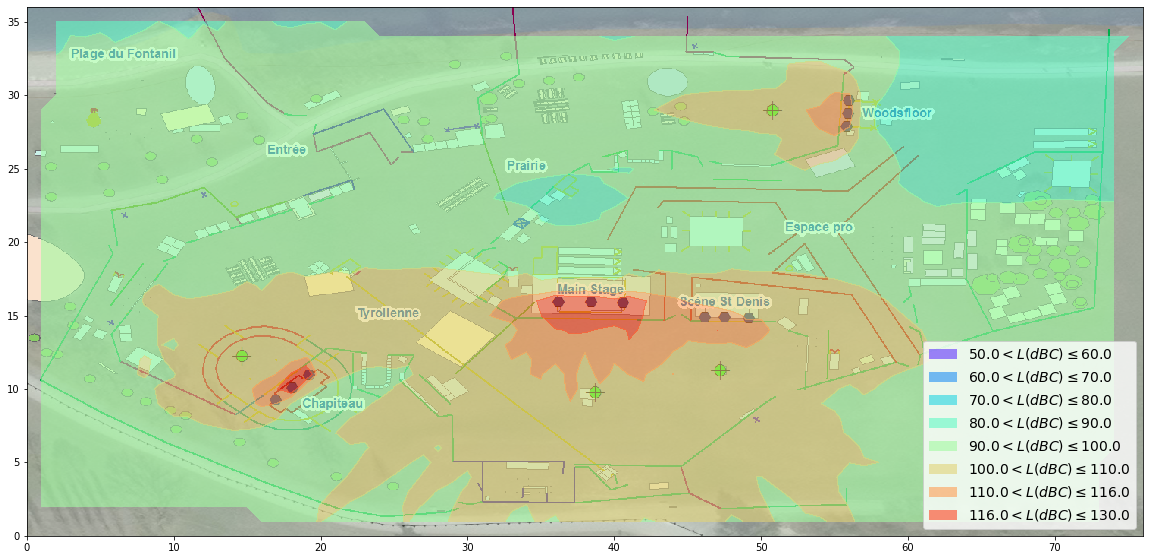

In [13]:
lst = list(Dico_Time.values())
GHM = AvgdB(lst)
DrawMapLegend( HM = GHM, image = 'Background3.png')